In [1]:
# Mount Google Drive locally
from google.colab import drive
drive.mount('/content/drive')

# Basics
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Statistics
import math
from scipy import stats
from scipy.stats import multivariate_normal, truncnorm

Mounted at /content/drive


# Calculate metrics
Code to obtain the four metrics showcased in the paper: containment, Jaccard, multiset Jaccard and the cardinality proportion (K)

In [ ]:
path_prefix = '/content/drive/My Drive/Data Discovery/data/datasets/' # path where the data is stored

def calculateMetrics(row):
  print("Row index:", row.name, " Dataset: ", row["ds_name"], row.name, " Attribute: ", row["att_name"], row.name, " Dataset 2: ", row["ds_name_2"], row.name, " Attribute: ", row["att_name_2"])

  ds1 = pd.read_csv(path_prefix + row["ds_name"], header = 0)
  col1 = ds1[row["att_name"]].str.lower().str.strip()
  ds2 = pd.read_csv(path_prefix + row["ds_name_2"], header = 0)
  col2 = ds2[row["att_name_2"]].str.lower().str.strip()

  set1 = set(col1)
  set2 = set(col2)

  intersection = len(set1.intersection(set2))
  union = len(set1.union(set2))
  lengthes = len(col1) + len(col2) # Careful! The lengthes are of the columns, not the set. That is, we include repeated values

  jaccard = intersection / union
  containment = intersection / min(len(set1), len(set2))
  multisetJaccard = intersection / lengthes
  k = min(len(set1),len(set2))/max(len(set1),len(set2))

  return pd.Series([containment, jaccard, multisetJaccard, k])

# Data loading

Load the ground truth. That is, a dataframe with joins (pairs of attributes from different datasets) and the following measurements: containment (C), cardinality proportion (K), Jaccard (J) and multiset Jaccard (MJ) scores. Additionally, each join is assigned a type of relationship (semantic or syntactic).

In [2]:
groundTruth = pd.read_csv('/content/drive/My Drive/Data Discovery/data/ground_truth_sem_or_syn.csv', header = 0)
groundTruth

,ds_name,att_name,ds_name_2,att_name_2,sizeDistinct1,sizeDistinct2,joinSize,C,K,J,MultisetJ,relationship
0,Distributions_data_2016.csv,demographics,Tech_sector_diversity_demographics_2016.csv,raceEthnicity,13,6,3,0.230769,0.461538,0.187500,0.000186,syntactic
1,USA_cars_datasets.csv,country,world_country.csv,Name,2,239,1,0.500000,0.008368,0.004167,0.000365,semantic
2,books_updated.csv,languageCode,countries_metadatacountries.csv,CountryCode,25,247,9,0.360000,0.101215,0.034091,0.000878,syntactic
3,cars.csv,color,colors.csv,name,12,135,9,0.750000,0.088889,0.065217,0.000233,semantic
4,cars.csv,transmission,imdb_ijs_movies.csv,name,2,45482,1,0.500000,0.000044,0.000022,0.000011,syntactic
...,...,...,...,...,...,...,...,...,...,...,...,...
4313,student-mat.csv,Pstatus,dataset_1_anneal.csv,temper_rolling,2,1,51,0.500000,0.500000,0.333333,0.000773,syntactic
4314,top10s.csv,title,song_data.csv,songname,584,12932,1,0.493151,0.045159,0.021567,0.014713,semantic
4315,top_100_books.csv,author2,books_updated.csv,authors,83,4636,288,0.409639,0.017903,0.006999,0.003268,semantic
4316,us_companies.csv,companytype,worldcitiespop.csv,Country,9,234,34,0.111111,0.038462,0.000000,0.000000,syntactic


# Initial experiments: which set-overlap metric to use?

Firstly, we want to assess whether multiset Jaccard (the metric that we want to explore the performance of) is better than traditional set overlap metrics (containment and Jaccard) in separating semantic from syntatic joins.

## Proportion of semantic-syntactic joins

We start by ordering the joins in three different "rankings", one per each set overlap metric, with higher values of the metrics being placed at the top. Then, we separate each ranking into its four quartiles, and measure the proportion of semantic and syntactic joins in each. Ideally, we should see that for quartiles 3 and 4 (i.e. those representing the the top 50% of joins according to the metrics), they have a higher proportion of semantic joins than buckets 1 and 2.

Note that the ground truth contains more syntactic than semantic joins.

**Result**: Containment is clearly worse than both Jaccard metrics in developing this separation. Multiset Jaccard seems to make the distribution slightly better than Jaccard, although the evidence is small.

In [ ]:
def proportions(metric, num_partitions):
  count_sem = 0
  count_syn = 0
  groundTruth[metric + '_rank'] = groundTruth[metric].rank(method="first", ascending=False)
  groundTruth['partition_' + metric] = pd.qcut(groundTruth[metric], q=num_partitions, labels=False) + 1

  # Initialize counts dictionary based on the number of partitions
  counts = {str(i): {'sem': 0, 'syn': 0} for i in range(1, num_partitions + 1)}

  # Count occurrences
  for index, row in groundTruth.iterrows():
      if row["relationship"] == "semantic":
          counts[str(row['partition_' + metric])]['sem'] += 1
      else:
          counts[str(row['partition_' + metric])]['syn'] += 1

  sem_counts = [counts[key]["sem"] for key in counts]
  syn_counts = [counts[key]["syn"] for key in counts]
  return sem_counts, syn_counts

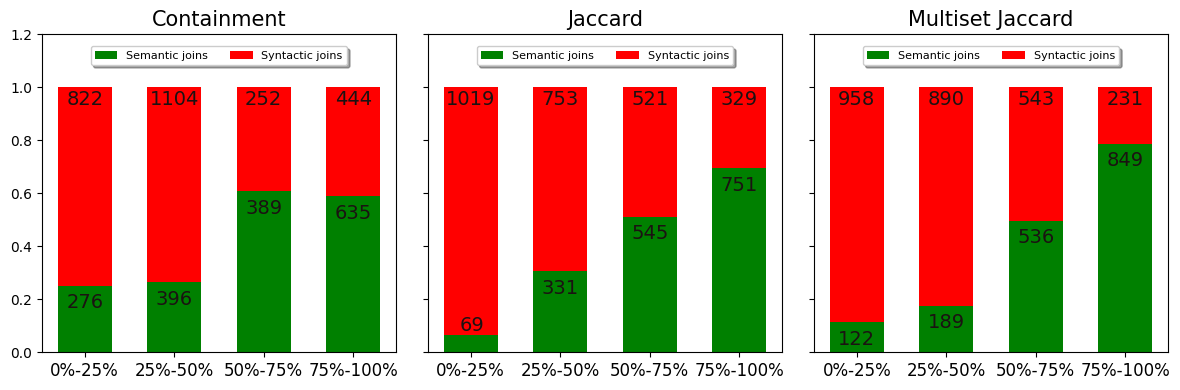

In [ ]:
proportions_c = proportions("C", 4)
proportions_j = proportions("J", 4)
proportions_mj = proportions("MultisetJ", 4)

values_sets = [
    (proportions_c[0], proportions_c[1], "Containment"),
    (proportions_j[0], proportions_j[1], "Jaccard"),
    (proportions_mj[0], proportions_mj[1], "Multiset Jaccard")
]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

categories = ['0%-25%', '25%-50%', '50%-75%', '75%-100%']
bar_width = 0.6
index = np.arange(len(categories))

for i, (values1, values2, title) in enumerate(values_sets):
    total_values = np.array(values1) + np.array(values2)
    normalized_values1 = np.array(values1) / total_values
    normalized_values2 = np.array(values2) / total_values

    ax = axs[i]

    bars1 = ax.bar(index, normalized_values1, bar_width, label='Semantic joins', color='green')
    bars2 = ax.bar(index, normalized_values2, bar_width, label='Syntactic joins', color='red', bottom=normalized_values1)

    ax.set_title(title, fontsize=15)
    ax.set_xticks(index)
    ax.set_xticklabels(categories, size=12)
    ax.set_ylim(0, 1.2)

    for bar1, bar2, val1, val2 in zip(bars1, bars2, values1, values2):
        if val1 == 69:  # Special case
            ax.text(bar1.get_x() + bar1.get_width() / 1.9, bar1.get_height(), val1, ha='center', va='bottom', color="#1B1212", size=14)
        else:
            ax.text(bar1.get_x() + bar1.get_width() / 2., bar1.get_height() - 0.1, val1, ha='center', va='bottom', color="#1B1212", size=14)
        ax.text(bar2.get_x() + bar2.get_width() / 2., bar2.get_height() + bar1.get_height() - 0.01, val2, ha='center', va='top', color="#1B1212", size=14)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.98), fancybox=True, shadow=True, ncol=2, fontsize=8)

plt.tight_layout()
plt.show()

## Precision at k

The previous experiment takes into consideration all the joins in the ground truth to assess the capacity of the metrics to separate semantic and syntactic joins. On a real scenario, the end user will only consider the top k joins (i.e. those with higher values of join quality). Hence, we will now focus only on the top joins.

To do so we will employ the precision at k (P@k) metric, which is similar to the previous procedure: how many of the top k joins are semantic joins? We will set k to 100, which is already far more than what a realistic end user would consider.

**Result**: We can observe that multiset Jaccard is clearly better at placing semantic joins in the top spots. In fact, both containment and Jaccard places syntactic joins in the first few positions, which means that the first joins to be given to the user would be false positives. We have a clear argument to prefer multiset Jaccard to the other two.

In [ ]:
def get_precisions(ranking, k_max):
  results = []
  for k in range(1, k_max + 1, 2):
    groundTruthSorted_k = groundTruth.sort_values(by=ranking).head(k)
    recall_k = (groundTruthSorted_k['relationship'] == "semantic").sum()/k
    results.append(recall_k)
  return results


def precision_at_k_set_overlap_metrics(k_max):
  c = get_precisions("C_rank", k_max)
  j = get_precisions("J_rank", k_max)
  mj = get_precisions("MultisetJ_rank", k_max)

  plt.figure(figsize=(6, 3))

  x = range(1, k_max + 1, 2)
  plt.plot(x, c, label='Containment')
  plt.plot(x, j, linestyle='-.', label='Jaccard')
  plt.plot(x, mj, linestyle='--', label='Multiset Jaccard')

  plt.xlabel('k', fontsize=14)
  plt.ylabel('P@k', fontsize=14)

  plt.xlim(-0.4, k_max + 1)
  plt.ylim(0, 1.03)
  plt.tick_params(axis='y', labelsize=12)
  plt.tick_params(axis='x', labelsize=12)

  plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, shadow=True, ncol=4, fontsize=12)

  plt.grid(True)
  plt.show()

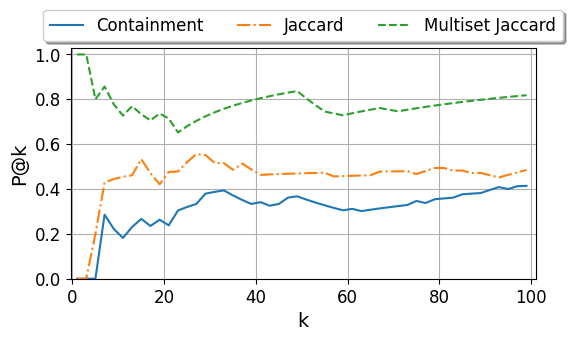

In [ ]:
precision_at_k_set_overlap_metrics(100)

# Relevance of K

We can justify the employment of the cardinality proportion in a preliminary manner by evaluating its capacity to segregate semantic from syntactic joins.

**Result**: The plots showcase a clear positive correlation between the value of the cardinality proportion and the amount of semantic joins. That is, higher values of K tend to correspond with semantic joins.

In [ ]:
def proportions_joined(metric, num_quantiles, sample_size=1500):
    # Sample data for semantic and syntactic relationships
    sem_sample = groundTruth[groundTruth["relationship"] == "semantic"].sample(n=sample_size, random_state=0)
    syn_sample = groundTruth[groundTruth["relationship"] == "syntactic"].sample(n=sample_size, random_state=0)
    combined_sample = pd.concat([sem_sample, syn_sample])

    # Rank the metric values and divide into quantiles
    combined_sample[metric + '_rank'] = combined_sample[metric].rank(method="first", ascending=False)
    combined_sample['quartile_' + metric] = pd.qcut(combined_sample[metric], q=num_quantiles, labels=False) + 1

    # Initialize counts dictionary
    quartile_counts = {i: {'sem': 0, 'syn': 0} for i in range(1, num_quantiles + 1)}

    # Count occurrences in each quartile
    for quartile, relationship in zip(combined_sample['quartile_' + metric], combined_sample['relationship']):
        if relationship == "semantic":
            quartile_counts[quartile]['sem'] += 1
        else:
            quartile_counts[quartile]['syn'] += 1

    # Extract counts for semantic and syntactic relationships
    sem_counts = [quartile_counts[q]['sem'] for q in sorted(quartile_counts.keys())]
    syn_counts = [quartile_counts[q]['syn'] for q in sorted(quartile_counts.keys())]

    print(f"Semantic counts for metric {metric}: {sem_counts}")
    print(f"Syntactic counts for metric {metric}: {syn_counts}")
    return sem_counts, syn_counts

Semantic counts for metric K: [107, 374, 470, 549]
Syntactic counts for metric K: [643, 377, 279, 201]


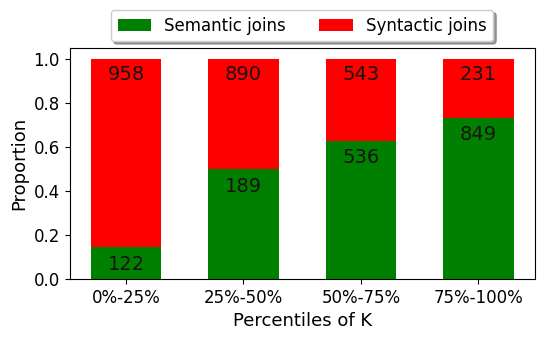

In [ ]:
values_sets = proportions_joined("K", 4) # [0] -> semantic counts, [1] -> syntactic counts

categories = ['0%-25%', '25%-50%', '50%-75%', '75%-100%']

# Normalizing the values
total_values = np.array(values_sets[0]) + np.array(values_sets[1])
semantic_values_normalized = np.array(values_sets[0]) / total_values
syntactic_values_normalized = np.array(values_sets[1]) / total_values

plt.figure(figsize=(6, 3))
index = np.arange(len(categories))

# Plotting the first section of bars
bars1 = plt.bar(index, semantic_values_normalized, 0.6, label='Semantic joins', color='green')

# Plotting the second section of bars on top of the first section
bars2 = plt.bar(index, syntactic_values_normalized, 0.6, label='Syntactic joins', color='red', bottom=semantic_values_normalized)

plt.ylabel('Proportion', fontsize=13)
plt.xlabel('Percentiles of K', fontsize=13)
plt.xticks(index, categories, size=12)
plt.yticks(size=12)
plt.ylim(0, 1.05)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, shadow=True, ncol=2, fontsize=12)

# Adding original values on top of the bars
for bar1, bar2, val1, val2 in zip(bars1, bars2, values1, values2):
    plt.text(bar1.get_x() + bar1.get_width() / 2., bar1.get_height() - 0.12, val1, ha='center', va='bottom', color="#1B1212", size=14)
    plt.text(bar2.get_x() + bar2.get_width() / 2., bar2.get_height() + bar1.get_height() - 0.03, val2, ha='center', va='top', color="#1B1212", size=14)

plt.show()

Semantic counts for metric K: [107, 374, 470, 549]
Syntactic counts for metric K: [643, 377, 279, 201]


<ipython-input-161-22235835050f>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(categories, rotation=45, ha='right')
<ipython-input-161-22235835050f>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(categories, rotation=45, ha='right')


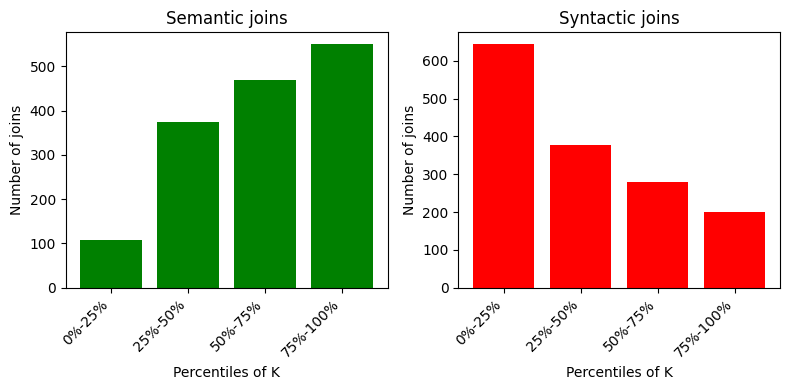

In [ ]:
values_sets = proportions_joined("K", 4) # [0] -> semantic counts, [1] -> syntactic counts

categories = ['0%-25%', '25%-50%', '50%-75%', '75%-100%']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Create the first bar plot
ax1.bar(categories, values_sets[0], color='green')
ax1.set_title('Semantic joins')
ax1.set_xlabel('Percentiles of K')
ax1.set_ylabel('Number of joins')
ax1.set_xticklabels(categories, rotation=45, ha='right')

# Create the second bar plot
ax2.bar(categories, values_sets[1], color='red')
ax2.set_title('Syntactic joins')
ax2.set_xlabel('Percentiles of K')
ax2.set_ylabel('Number of joins')
ax2.set_xticklabels(categories, rotation=45, ha='right')

fig.tight_layout()
plt.show()

# Multi-class metric

By plotting the scores for MJ and K obtained by the ground truth, we can observe a positive correlation between the values of the metrics and the semantic category of the joins. That is, the higher the values of MJ and K, the more likely for a join to be semantic.

Hence, we define a multiclass function that maps the instance of the ground truth onto four (by default, but there might be many levels), quality categories. The idea is that the "higher" buckets should contain a higher proportion of semantic joins compared to syntactic joins. It is important to realize that this is not meant to define 100% accurate thresholds (as it is impossible), but rather to capture general trends.

We also plot the result of applying such function over our ground truth.

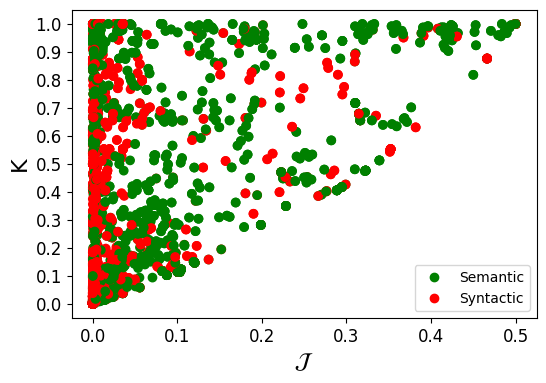

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def pltcolor(lst):
    cols = []
    for l in lst:
        if l == 'semantic':
            cols.append(0)
        elif l == 'syntactic':
            cols.append(1)
        else:
            cols.append(2)
    return cols

cols = pltcolor(groundTruth['relationship'])

classes = ['Semantic', 'Syntactic']
colours = mcolors.ListedColormap(['g', 'b', 'r'])

plt.figure(figsize=(6, 4))

scatter = plt.scatter(groundTruth["MultisetJ"], groundTruth["K"], c=cols, cmap=colours)
plt.xticks(np.linspace(0, 0.5, 6), fontsize=12)
plt.yticks(np.linspace(0, 1, 11), fontsize=12)
plt.xlabel(r'$\mathcal{J}$', fontsize=16)
plt.ylabel('K', fontsize=16)

plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

In [6]:
def discreteQuality(MJ, K, L):
  for i in range(0,L): # range() does not include the last element
    if MJ >= 1/2**(i+1) and K >= 1-(i/(L)): # i + 1 as Mj is bounded in [0, 0.5] (i + 1 is equivalent to 2 * MJ)
      return (L-i+1)/L
  return 0

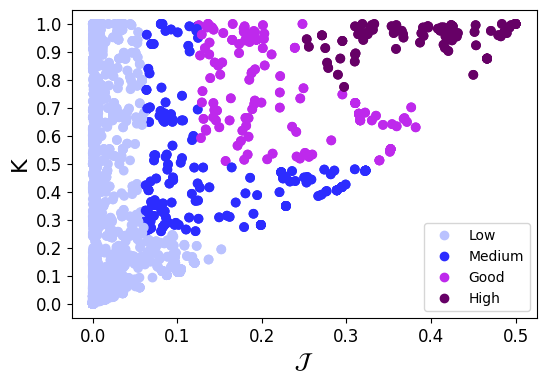

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

groundTruth['discreteQuality'] = groundTruth.apply(lambda row: discreteQuality(row['MultisetJ'], row['K'], 4), axis=1)

classes = ['Low', 'Medium', 'Good', 'High']
colours = mcolors.ListedColormap(['#bac2ff', '#2c2cff', '#be29ec', '#660066'])

plt.figure(figsize=(6, 4))
plt.xticks(np.linspace(0, 1, 11), fontsize=12)
plt.yticks(np.linspace(0, 1, 11), fontsize=12)
scatter = plt.scatter(groundTruth['MultisetJ'], groundTruth['K'], c=groundTruth['discreteQuality'], cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.xlabel(r'$\mathcal{J}$', fontsize=16)
plt.ylabel('K', fontsize=16)

plt.show()

# Continuous metric
Finally, we transform the multi-class metric to a continuous one, as it would allow us to create rankings. To do so, we fit a multiple Gaussian distribution over the multi-class metric.

In [9]:
def defineModel(mu_MJ, mu_K, sigma_mj, sigma_k):
  mu_v = [mu_MJ , mu_K] # Mean vector
  """
  The covariance matrix is defined as:
  cov = [[sigma_v[0]**2, 0],
        [0, sigma_v[1]**2]]
  """
  sigma_v = [sigma_mj, sigma_k] # Variance vector (we assume an equal sigma for MJ and K)
  a1, b1 = (- mu_v[0]) / sigma_v[0], (1 - mu_v[0]) / sigma_v[0] # Defining MJ limits
  a2, b2 = (- mu_v[1]) / sigma_v[1], (1 - mu_v[1]) / sigma_v[1] # Defining K limits
  MJmodel = truncnorm(a1, b1, scale=sigma_v[0], loc=mu_v[0]) # Creating MJ model
  Kmodel = truncnorm(a2, b2, scale=sigma_v[1], loc=mu_v[1]) # Creating K model
  return MJmodel,Kmodel

def continuousJoinQualityWithAll(MJ,K,MJmodel,Kmodel):
  return MJmodel.cdf(MJ)*Kmodel.cdf(K)

Best mu for MJ is 0.1111111111111111
Best sigma for MJ is 0.1
Best wasserstein_distance for MJ is 0.06743474780215303


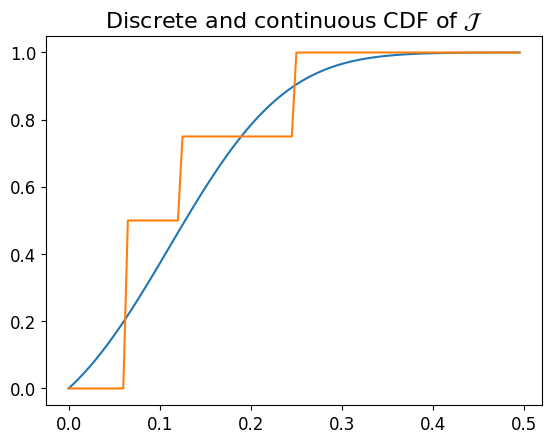

Best mu for K is 0.4444444444444444
Best sigma for K is 0.19
Best wasserstein_distance for K is 0.08269476814368401


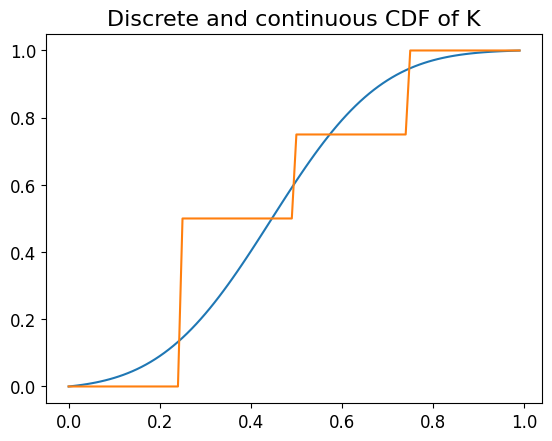

In [25]:
def evaluate_model(mu_values, sigma_values, L, is_MJ_model=True):
    best_mu = 1
    best_sigma = 1
    best_distance = math.inf

    for mu in mu_values:
        for sigma in sigma_values:
            cdf_model = []
            discrete_model = []

            if is_MJ_model:
                MJmodel, Kmodel = defineModel(mu, 0, sigma, 0.5)
                X = np.arange(0, 0.5, 0.005)
            else:
                MJmodel, Kmodel = defineModel(0, mu, 0.5, sigma)
                X = np.arange(0, 1, 0.01)

            for x in X:
                if is_MJ_model:
                    cdfVal = continuousJoinQualityWithAll(x, 1, MJmodel, Kmodel)
                    discreteVal = discreteQuality(x, 1, L)
                else:
                    cdfVal = continuousJoinQualityWithAll(1, x, MJmodel, Kmodel)
                    discreteVal = discreteQuality(1, x, L)

                cdf_model.append(cdfVal)
                discrete_model.append(discreteVal)

            d = stats.wasserstein_distance(cdf_model, discrete_model)
            if d < best_distance:
                best_distance = d
                best_mu = mu
                best_sigma = sigma

    return best_mu, best_sigma, best_distance

def plot_models(mu, sigma, L, is_MJ_model=True):
    if is_MJ_model:
        MJmodel, Kmodel = defineModel(mu, 0, sigma, 0.5)
        X = np.arange(0, 0.5, 0.005)
    else:
        MJmodel, Kmodel = defineModel(0, mu, 0.5, sigma)
        X = np.arange(0, 1, 0.01)

    models = []
    cdf_model = []
    discrete_model = []

    for x in X:
        if is_MJ_model:
            cdfVal = continuousJoinQualityWithAll(x, 1, MJmodel, Kmodel)
            discreteVal = discreteQuality(x, 1, L)
        else:
            cdfVal = continuousJoinQualityWithAll(1, x, MJmodel, Kmodel)
            discreteVal = discreteQuality(1, x, L)

        cdf_model.append(cdfVal)
        discrete_model.append(discreteVal)
        models.append([cdfVal, discreteVal])

    plt.plot(X, models)
    title = "Discrete and continuous CDF of $\mathcal{J}$" if is_MJ_model else "Discrete and continuous CDF of K"
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

L = 4
mu_values = np.linspace(0, 1, 10, endpoint=True)
sigma_values = np.linspace(0.1, 1, 10, endpoint=False)

best_mu_MJ, best_sigma_MJ, best_distance_MJ = evaluate_model(mu_values, sigma_values, L, is_MJ_model=True)
print("Best mu for MJ is", best_mu_MJ)
print("Best sigma for MJ is", best_sigma_MJ)
print("Best wasserstein_distance for MJ is", best_distance_MJ)
plot_models(best_mu_MJ, best_sigma_MJ, L, is_MJ_model=True)

best_mu_K, best_sigma_K, best_distance_K = evaluate_model(mu_values, sigma_values, L, is_MJ_model=False)
print("Best mu for K is", best_mu_K)
print("Best sigma for K is", best_sigma_K)
print("Best wasserstein_distance for K is", best_distance_K)
plot_models(best_mu_K, best_sigma_K, L, is_MJ_model=False)

# Strictness

Finally, we will provide the metric with some capacity to generalize by defining a strictness modifier. The higher the strictness, the more restrictive it will be when defining the scoring of the joins. That is, a higher strictness value implies that the higher scores of MJ and K are necessary to achieve a high join quality score. We define three levels: relaxed, balanced (which is the one we build the final model with) and strict.

In [14]:
def continuousJoinQuality(MJ,K,strictness):
  mu_v = [0.44 + 0.25*strictness, 0 + 0.25*strictness]
  """
  The covariance matrix is defined as:
  cov = [[sigma_v[0]**2, 0],
        [0, sigma_v[1]**2]]
  """
  sigma_v = [0.19, 0.28]
  a1, b1 = (- mu_v[0]) / sigma_v[0], (1 - mu_v[0]) / sigma_v[0]
  a2, b2 = (- mu_v[1]) / sigma_v[1], (1 - mu_v[1]) / sigma_v[1]
  MJmodel = truncnorm(a1, b1, scale=sigma_v[0], loc=mu_v[0])
  Kmodel = truncnorm(a2, b2, scale=sigma_v[1], loc=mu_v[1])
  return MJmodel.cdf(MJ)*Kmodel.cdf(K)

In [19]:
groundTruth['relaxedContinousJoinQuality'] = groundTruth.apply(lambda row: continuousJoinQuality(row['MultisetJ'],row['K'], 0), axis=1)
groundTruth['balancedContinousJoinQuality'] = groundTruth.apply(lambda row: continuousJoinQuality(row['MultisetJ'],row['K'], 0.5), axis=1)
groundTruth['strictContinousJoinQuality'] = groundTruth.apply(lambda row: continuousJoinQuality(row['MultisetJ'],row['K'], 1), axis=1)

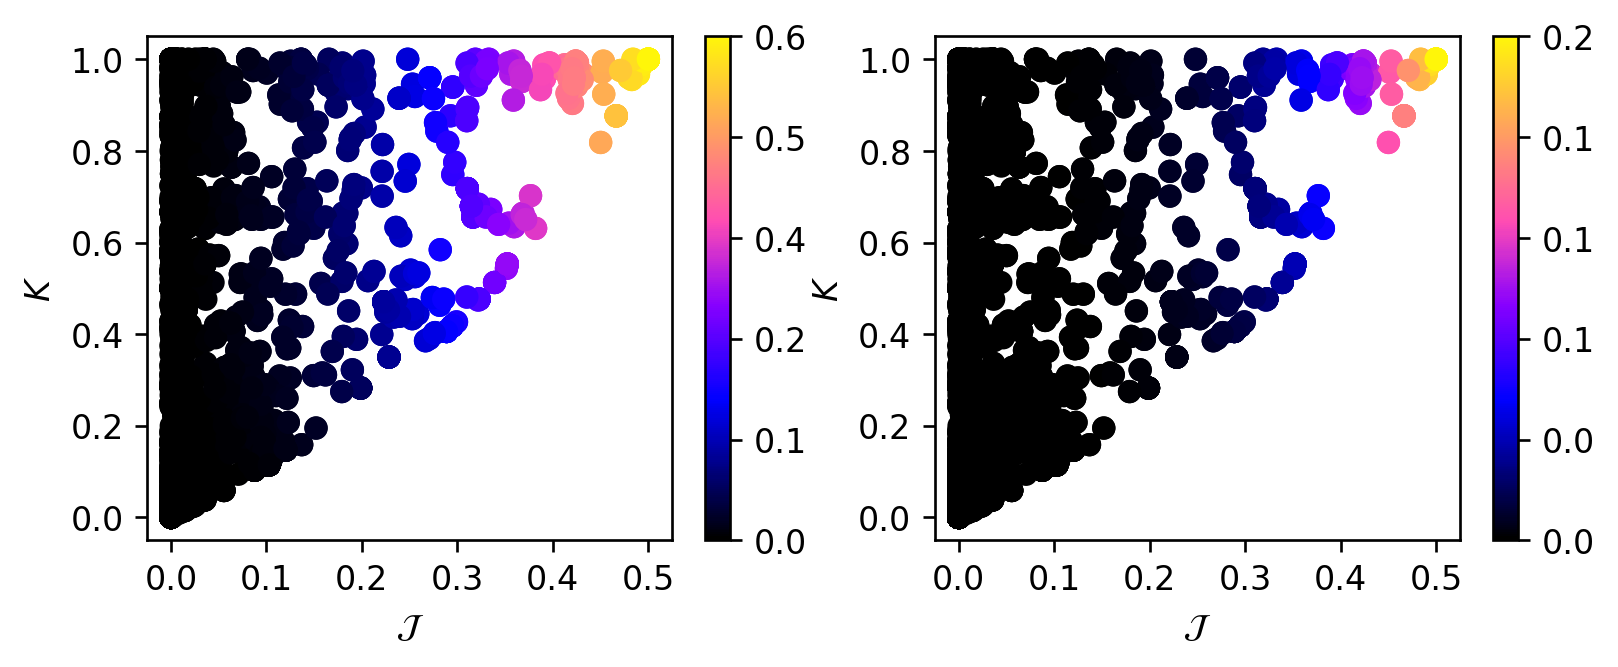

In [20]:
cmap = plt.get_cmap('gnuplot2')
colors = cmap(np.linspace(0, 0.9, 256))
darker_cmap = mcolors.ListedColormap(colors)

custom_ticks = np.linspace(0, 1, 6)
x_custom_ticks = np.linspace(0, 0.5, 6)

def create_scatter_plot(ax, x_data, y_data, color_data, cmap, custom_ticks, x_custom_ticks):
    scatter = ax.scatter(x_data, y_data, c=color_data, cmap=cmap)
    cbar = plt.colorbar(scatter, ax=ax)
    max_val = color_data.max()
    custom_ticks = np.linspace(0, max_val, 6)
    cbar.set_ticks(custom_ticks)
    cbar.set_ticklabels([f'{tick:.1f}' for tick in custom_ticks])
    ax.set_xticks(x_custom_ticks)
    ax.set_xticklabels([f'{tick:.1f}' for tick in x_custom_ticks])
    ax.set_xlabel(r'$\mathcal{J}$')
    ax.set_ylabel("$K$")

fig = plt.figure(figsize=(12, 6), dpi=240)

data = [
    ('relaxedContinousJoinQuality', 'MultisetJ', 'K'),
    # ('balancedContinousJoinQuality', 'MultisetJ', 'K'),
    ('strictContinousJoinQuality', 'MultisetJ', 'K')
]

for i, (color_data_key, x_data_key, y_data_key) in enumerate(data, start=1):
    ax = fig.add_subplot(2, 3, i)
    create_scatter_plot(
        ax,
        groundTruth[x_data_key],
        groundTruth[y_data_key],
        groundTruth[color_data_key],
        darker_cmap,
        custom_ticks,
        x_custom_ticks
    )

# Comparing rankings

To evaluate the results of combining Mj and K, we can compare it to the rankings generated only with MJ (showcased at the beginning of the notebook), a slightly modified continuous join quality metric (defined below) and the continuous join quality metrics for Jaccard and Containment.

We perform this comparison by:
- Total number of correct positions (that is, semantics in the top positions, syntactic in the lower ones).
- Number of mistaken spaces: given a join that is not correctly classified, how many positions should it move to reach a "correct" position.
- Quadratic number of mistaken positions: same as before but squaring the distances, which applies a stronger penalization to further mispositions.
- Precision@100, as done in the introduction.

**Result**: The continuous join quality defined with Multiset Jaccard, and its subsequent ranking, is the best performing in most of the metrics. It is only slightly surpassed by its alternative formulation in the quadratic number of mistaken positions, and tied in Precision@k. In any case, the improvement over the base Multiset Jaccard ranking (which was already better than Jaccard and containment) is noticeable.

In [ ]:
def continuousJoinQualityC(C,K,strictness):
  mu_v = [0.44 + 0.25*strictness, 0 + 0.25*strictness]
  """
  The covariance matrix is defined as:
  cov = [[sigma_v[0]**2, 0],
        [0, sigma_v[1]**2]]
  """
  sigma_v = [0.19, 0.28]
  a1, b1 = (- mu_v[0]) / sigma_v[0], (1 - mu_v[0]) / sigma_v[0]
  a2, b2 = (- mu_v[1]) / sigma_v[1], (1 - mu_v[1]) / sigma_v[1]
  Cmodel = truncnorm(a1, b1, scale=sigma_v[0], loc=mu_v[0])
  Kmodel = truncnorm(a2, b2, scale=sigma_v[1], loc=mu_v[1])
  return Cmodel.cdf(C)*Kmodel.cdf(K)

def continuousJoinQuality_2(MJ,K,strictness):
  mu_v = [0.0 + 0.25*strictness, 0. + 0.25*strictness]
  """
  The covariance matrix is defined as:
  cov = [[sigma_v[0]**2, 0],
        [0, sigma_v[1]**2]]
  """
  sigma_v = [0.1, 0.37]
  a1, b1 = (- mu_v[0]) / sigma_v[0], (1 - mu_v[0]) / sigma_v[0]
  a2, b2 = (- mu_v[1]) / sigma_v[1], (1 - mu_v[1]) / sigma_v[1]
  MJmodel = truncnorm(a1, b1, scale=sigma_v[0], loc=mu_v[0])
  Kmodel = truncnorm(a2, b2, scale=sigma_v[1], loc=mu_v[1])
  return MJmodel.cdf(MJ)*Kmodel.cdf(K)

In [ ]:
groundTruth['cjqC'] = groundTruth.apply(lambda row: continuousJoinQualityC(row['C'],row['K'], 0.25), axis=1)
groundTruth['cjqJ'] = groundTruth.apply(lambda row: continuousJoinQualityC(row['J'],row['K'], 0.25), axis=1)
groundTruth['cjqMultisetJ'] = groundTruth.apply(lambda row: continuousJoinQuality(row['MultisetJ'],row['K'], 0.25), axis=1)
groundTruth['cjqMultisetJ_2'] = groundTruth.apply(lambda row: continuousJoinQuality_2(row['MultisetJ'],row['K'], 0.25), axis=1)

groundTruth

,ds_name,att_name,ds_name_2,att_name_2,sizeDistinct1,sizeDistinct2,joinSize,C,K,J,MultisetJ,relationship,MultisetJ_rank,cjqC,cjqJ,cjqMultisetJ,cjqMultisetJ_2
0,Distributions_data_2016.csv,demographics,Tech_sector_diversity_demographics_2016.csv,raceEthnicity,13,6,3,0.230769,0.461538,0.187500,0.000186,syntactic,3218.0,0.063367,3.910159e-02,1.041278e-05,6.340111e-04
1,USA_cars_datasets.csv,country,world_country.csv,Name,2,239,1,0.500000,0.008368,0.004167,0.000365,semantic,2929.0,0.009820,5.458188e-06,4.659192e-07,2.594699e-05
2,books_updated.csv,languageCode,countries_metadatacountries.csv,CountryCode,25,247,9,0.360000,0.101215,0.034091,0.000878,syntactic,2641.0,0.054708,6.777717e-04,1.381148e-05,7.626005e-04
3,cars.csv,color,colors.csv,name,12,135,9,0.750000,0.088889,0.065217,0.000233,semantic,3102.0,0.194229,1.423813e-03,3.200301e-06,1.771393e-04
4,cars.csv,transmission,imdb_ijs_movies.csv,name,2,45482,1,0.500000,0.000044,0.000022,0.000011,syntactic,3951.0,0.000051,1.465678e-10,7.529394e-11,4.204510e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4313,student-mat.csv,Pstatus,dataset_1_anneal.csv,temper_rolling,2,1,51,0.500000,0.500000,0.333333,0.000773,syntactic,2688.0,0.445479,1.657404e-01,4.488233e-05,2.769166e-03
4314,top10s.csv,title,song_data.csv,songname,584,12932,1,0.493151,0.045159,0.021567,0.014713,semantic,1498.0,0.051987,1.741488e-04,1.131892e-04,5.915412e-03
4315,top_100_books.csv,author2,books_updated.csv,authors,83,4636,288,0.409639,0.017903,0.006999,0.003268,semantic,1957.0,0.013250,2.007347e-05,9.130448e-06,5.020441e-04
4316,us_companies.csv,companytype,worldcitiespop.csv,Country,9,234,34,0.111111,0.038462,0.000000,0.000000,syntactic,4318.0,0.001449,0.000000e+00,0.000000e+00,0.000000e+00


In [ ]:
groundTruth['MultisetJ_rank'] = groundTruth['MultisetJ'].rank(method="first", ascending=False)
groundTruth['cjqMultisetJ_rank'] = groundTruth['cjqMultisetJ'].rank(method="first", ascending=False)
groundTruth['cjqMultisetJ_2_rank'] = groundTruth['cjqMultisetJ_2'].rank(method="first", ascending=False)
groundTruth['cjqC_rank'] = groundTruth['cjqC'].rank(method="first", ascending=False)
groundTruth['cjqJ_rank'] = groundTruth['cjqJ'].rank(method="first", ascending=False)

groundTruth

,ds_name,att_name,ds_name_2,att_name_2,sizeDistinct1,sizeDistinct2,joinSize,C,K,J,...,relationship,MultisetJ_rank,cjqC,cjqJ,cjqMultisetJ,cjqMultisetJ_2,cjqMultisetJ_rank,cjqMultisetJ_2_rank,cjqC_rank,cjqJ_rank
0,Distributions_data_2016.csv,demographics,Tech_sector_diversity_demographics_2016.csv,raceEthnicity,13,6,3,0.230769,0.461538,0.187500,...,syntactic,3218.0,0.063367,3.910159e-02,1.041278e-05,6.340111e-04,2642.0,2631.0,2126.0,1469.0
1,USA_cars_datasets.csv,country,world_country.csv,Name,2,239,1,0.500000,0.008368,0.004167,...,semantic,2929.0,0.009820,5.458188e-06,4.659192e-07,2.594699e-05,3246.0,3246.0,2948.0,3232.0
2,books_updated.csv,languageCode,countries_metadatacountries.csv,CountryCode,25,247,9,0.360000,0.101215,0.034091,...,syntactic,2641.0,0.054708,6.777717e-04,1.381148e-05,7.626005e-04,2582.0,2593.0,2184.0,2610.0
3,cars.csv,color,colors.csv,name,12,135,9,0.750000,0.088889,0.065217,...,semantic,3102.0,0.194229,1.423813e-03,3.200301e-06,1.771393e-04,2886.0,2902.0,1643.0,2487.0
4,cars.csv,transmission,imdb_ijs_movies.csv,name,2,45482,1,0.500000,0.000044,0.000022,...,syntactic,3951.0,0.000051,1.465678e-10,7.529394e-11,4.204510e-09,3965.0,3965.0,3951.0,3956.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4313,student-mat.csv,Pstatus,dataset_1_anneal.csv,temper_rolling,2,1,51,0.500000,0.500000,0.333333,...,syntactic,2688.0,0.445479,1.657404e-01,4.488233e-05,2.769166e-03,2293.0,2288.0,1222.0,1138.0
4314,top10s.csv,title,song_data.csv,songname,584,12932,1,0.493151,0.045159,0.021567,...,semantic,1498.0,0.051987,1.741488e-04,1.131892e-04,5.915412e-03,1980.0,2013.0,2203.0,2781.0
4315,top_100_books.csv,author2,books_updated.csv,authors,83,4636,288,0.409639,0.017903,0.006999,...,semantic,1957.0,0.013250,2.007347e-05,9.130448e-06,5.020441e-04,2661.0,2694.0,2781.0,3039.0
4316,us_companies.csv,companytype,worldcitiespop.csv,Country,9,234,34,0.111111,0.038462,0.000000,...,syntactic,4318.0,0.001449,0.000000e+00,0.000000e+00,0.000000e+00,4318.0,4318.0,3450.0,4318.0


In [ ]:
def count_correct_rankings(ranking):
  count_correct_semantic = 0
  count_correct_syntactic = 0
  for index, row in groundTruth.iterrows():
    if (row['relationship'] == "semantic" and row[ranking] < 1696):
      count_correct_semantic = count_correct_semantic + 1
    elif (row['relationship'] == "syntactic" and row[ranking] > 1696):
      count_correct_syntactic = count_correct_syntactic + 1
  print(ranking, "-------", "Correct semantic:", count_correct_semantic, "Correct syntactic:", count_correct_syntactic)

In [ ]:
count_correct_rankings("MultisetJ_rank")
count_correct_rankings("cjqMultisetJ_rank")
count_correct_rankings("cjqMultisetJ_2_rank")
count_correct_rankings("cjqC_rank")
count_correct_rankings("cjqJ_rank")

MultisetJ_rank ------- Correct semantic: 1203 Correct syntactic: 2129
cjqMultisetJ_rank ------- Correct semantic: 1207 Correct syntactic: 2133
cjqMultisetJ_2_rank ------- Correct semantic: 1196 Correct syntactic: 2123
cjqC_rank ------- Correct semantic: 1069 Correct syntactic: 1995
cjqJ_rank ------- Correct semantic: 1051 Correct syntactic: 1977


In [ ]:
def count_mistaken_positions(ranking):
  count_mistaken_positions_semantic = 0
  count_mistaken_positions_syntactic = 0
  for index, row in groundTruth.iterrows():
    if (row['relationship'] == "semantic" and row[ranking] > 1696):
      count_mistaken_positions_semantic = count_mistaken_positions_semantic + (row[ranking] - 1696)
    elif (row['relationship'] == "syntactic" and row[ranking] < 1696):
      count_mistaken_positions_syntactic = count_mistaken_positions_syntactic + (-row[ranking] + 1696)
  print(f"{ranking} ------- Mistaken positions semantic: {count_mistaken_positions_semantic:,} Mistaken positions syntactic: {count_mistaken_positions_syntactic:,}")

In [ ]:
count_mistaken_positions("MultisetJ_rank")
count_mistaken_positions("cjqMultisetJ_rank")
count_mistaken_positions("cjqMultisetJ_2_rank")
count_mistaken_positions("cjqC_rank")
count_mistaken_positions("cjqJ_rank")

MultisetJ_rank ------- Mistaken positions semantic: 460,557.0 Mistaken positions syntactic: 355,964.0
cjqMultisetJ_rank ------- Mistaken positions semantic: 414,594.0 Mistaken positions syntactic: 356,484.0
cjqMultisetJ_2_rank ------- Mistaken positions semantic: 413,590.0 Mistaken positions syntactic: 357,101.0
cjqC_rank ------- Mistaken positions semantic: 525,836.0 Mistaken positions syntactic: 504,939.0
cjqJ_rank ------- Mistaken positions semantic: 504,016.0 Mistaken positions syntactic: 499,430.0


In [ ]:
def count_mistaken_positions_quadratic(ranking):
  count_mistaken_positions_semantic = 0
  count_mistaken_positions_syntactic = 0
  for index, row in groundTruth.iterrows():
    if (row['relationship'] == "semantic" and row[ranking] > 1696):
      count_mistaken_positions_semantic = count_mistaken_positions_semantic + ((row[ranking] - 1696) ** 2)
    elif (row['relationship'] == "syntactic" and row[ranking] < 1696):
      count_mistaken_positions_syntactic = count_mistaken_positions_syntactic + ((-row[ranking] + 1696) ** 2)
  print(f"{ranking} ------- Mistaken quadratic positions semantic: {count_mistaken_positions_semantic:,} Mistaken quadratic positions syntactic: {count_mistaken_positions_syntactic:,}")

In [ ]:
count_mistaken_positions_quadratic("MultisetJ_rank")
count_mistaken_positions_quadratic("cjqMultisetJ_rank")
count_mistaken_positions_quadratic("cjqMultisetJ_2_rank")
count_mistaken_positions_quadratic("cjqC_rank")
count_mistaken_positions_quadratic("cjqJ_rank")

MultisetJ_rank ------- Mistaken quadratic positions semantic: 663,680,537.0 Mistaken quadratic positions syntactic: 379,189,732.0
cjqMultisetJ_rank ------- Mistaken quadratic positions semantic: 562,732,812.0 Mistaken quadratic positions syntactic: 379,635,866.0
cjqMultisetJ_2_rank ------- Mistaken quadratic positions semantic: 561,168,018.0 Mistaken quadratic positions syntactic: 377,576,521.0
cjqC_rank ------- Mistaken quadratic positions semantic: 652,927,148.0 Mistaken quadratic positions syntactic: 583,376,315.0
cjqJ_rank ------- Mistaken quadratic positions semantic: 610,433,968.0 Mistaken quadratic positions syntactic: 556,253,358.0


In [ ]:
def get_precisions(ranking, k_max):
  results = []
  for k in range(1, k_max + 1, 2):
    groundTruthSorted_k = groundTruth.sort_values(by=ranking).head(k)
    recall_k = (groundTruthSorted_k['relationship'] == "semantic").sum()/k
    results.append(recall_k)
  return results


def precision_at_k_continous_metrics(k_max):
  cjqC = get_precisions("cjqC_rank", k_max)
  cjqJ = get_precisions("cjqJ_rank", k_max)
  cjqMJ = get_precisions("cjqMultisetJ_rank", k_max)
  cjqMJ_2 = get_precisions("cjqMultisetJ_2_rank", k_max)
  mj = get_precisions("MultisetJ_rank", k_max)

  plt.figure(figsize=(6, 3))

  x = range(1, k_max + 1, 2)
  plt.plot(x, cjqC, label='CJQ Containment')
  plt.plot(x, cjqJ, linestyle='-.', label='CJQ Jaccard')
  plt.plot(x, cjqMJ_2, linestyle='--', label='CJQ Multiset Jaccard')
  plt.plot(x, cjqMJ_2, linestyle=':', label='CJQ Multiset Jaccard 2')
  plt.plot(x, mj, linestyle='solid', label='Multiset Jaccard')

  plt.xlabel('k', fontsize=14)
  plt.ylabel('P@k', fontsize=14)

  plt.xlim(-0.4, k_max + 1)
  plt.ylim(0, 1.03)
  plt.tick_params(axis='y', labelsize=12)
  plt.tick_params(axis='x', labelsize=12)

  plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, shadow=True, ncol=5, fontsize=10)

  plt.grid(True)
  plt.show()

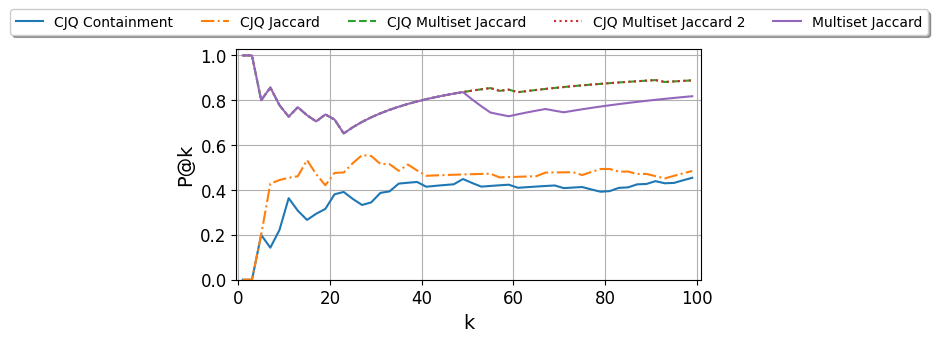

In [ ]:
precision_at_k_continous_metrics(100)